# Sanity check face relighting experiments

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from torch import nn
from torchvision import transforms
import torchvision.models as models
import torch
#from kornia import color

from kornia_lab import RgbToLab, LabToRgb

from torch.autograd import Variable

import faces.preparation as prep
from faces import face_utils

%load_ext autoreload
%autoreload 2

In [2]:
# Set up transformations

r2l = RgbToLab()
l2r = LabToRgb()

# SH initial values:

# Some valid relighting sample taken from the original paper/code"
sh = [
    1.084125496282453138e+00,
    -4.642676300617166185e-01,
    2.837846795150648915e-02,
    6.765292733937575687e-01,
    -3.594067725393816914e-01,
    4.790996460111427574e-02,
    -2.280054643781863066e-01,
    -8.125983081159608712e-02,
    2.881082012687687932e-01]

shs = [np.array(sh) * 0.7]

## ImageNet visualizations

First we load the image and do the necessary preprocessing for alexnet

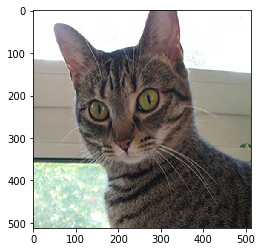

In [3]:
data_path = "../../data"

#img_path = "merkel_crop.jpg"
img_path = "imagenet-cat.png"

img_np = prep.load_np_img(img_path)
plt.imshow(img_np)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(img_np).double()
input_batch = input_tensor.unsqueeze(0)

In [4]:
model = models.alexnet(pretrained=True).double()
model.eval()
output = model(input_batch)
orig_label = torch.argmax(output)
print(orig_label.item())
print('281: tabby, tabby cat')
y_target = torch.from_numpy(np.array([orig_label.item()])).long()
_img = input_batch.clone().detach().requires_grad_(True)

281
281: tabby, tabby cat


Look at a relighting of this image using DPR

Note: the relighting is performed after the preprocessing

TODO: Discussion whether we do the preprocessing after or before the relighting

## Preprocessing for dpr-net

In [5]:
img_luv = prep.np_rgb_to_torch_luv(img_np)

# 3, 512, 512 -> 512, 512, 3
#img_luv = img_luv.transpose(0,2)

inputL = img_luv[0,:, :]
inputL = (inputL/100.0)
inputL = inputL[None,None, ...]

relighting_input = inputL.cuda().float()

Load relighting model

In [6]:
modelFolder = 'DPR/trained_model/'

from faces.DPR.model.defineHourglass_512_gray_skip import HourglassNet
my_network = HourglassNet()
my_network.load_state_dict(torch.load(os.path.join(modelFolder, 'trained_model_03.t7')))
my_network.cuda()
my_network.train(False);

## Generate a sample relighting


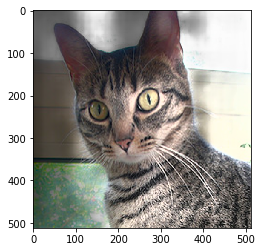

In [7]:
for sh in shs:
    sh = np.reshape(sh, (1,9,1,1)).astype(np.float32)
    sh = Variable(torch.from_numpy(sh).cuda())
    outputImg, outputSH  = my_network(relighting_input, sh, 0)
    outputImg = outputImg[0].data.cpu()
    outputImg = outputImg.permute((1,2,0))
    outputImg = torch.squeeze(outputImg)
    outputImg = (outputImg*100.0)

    output_luv = img_luv
    output_luv[0,:,:] = outputImg

    output_rgb = l2r.lab_to_rgb(output_luv)

    # 3, 512, 512 -> 512, 512, 3
    output_rgb= output_rgb.permute(1,2,0)
    
    # Mak sure we don't exceed 
    output_rgb = output_rgb.clamp(0.,1.)

    plt.figure()
    plt.imshow(output_rgb)

plt.show()

## Adversarial attack by relighting using (unconstrained) gradient ascent

### Preparation

In [8]:
# Initialize sh parameters
# One of the valid SH from the paper
sh = shs[0]

# Optionally random init for sh
#sh = shs[0] + np.random.rand(9) * 1 -0.5

# Preparation
sh = np.reshape(sh, (1,9,1,1)).astype(np.float32)
sh = Variable(torch.from_numpy(sh).cuda(), requires_grad=True)
# Initialize relighting model
relighting = my_network

classifier = model.cuda()

original_label = y_target.cuda()

learning_rate = 0.1
loss_history = []

adversarial_img_found = False
max_steps = 1000
# Alexnet norm params
mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])
norm = transforms.Compose([
    #transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
])


# Separate into l and uv dims
input_l = img_luv[0,:, :]
input_l = (input_l/100.0) # DPR expects values between 0 and 1
input_l = input_l[None,None, ...]

input_uv = img_luv[1:,:,: ].cuda()

input_l = input_l.cuda().float()

# Is this a targeted attack?
targeted = False
target_label = 666


sign = -1 if targeted else 1

### Optimization loop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Successfully found adversarial example after 9 steps
original class: 281
predicted class: 901
SH params: tensor([[[[ 1.4182]],

         [[-0.8588]],

         [[-0.1257]],

         [[ 1.6178]],

         [[-0.4970]],

         [[ 0.2737]],

         [[-0.2015]],

         [[-0.1810]],

         [[ 0.0517]]]], device='cuda:0', requires_grad=True)


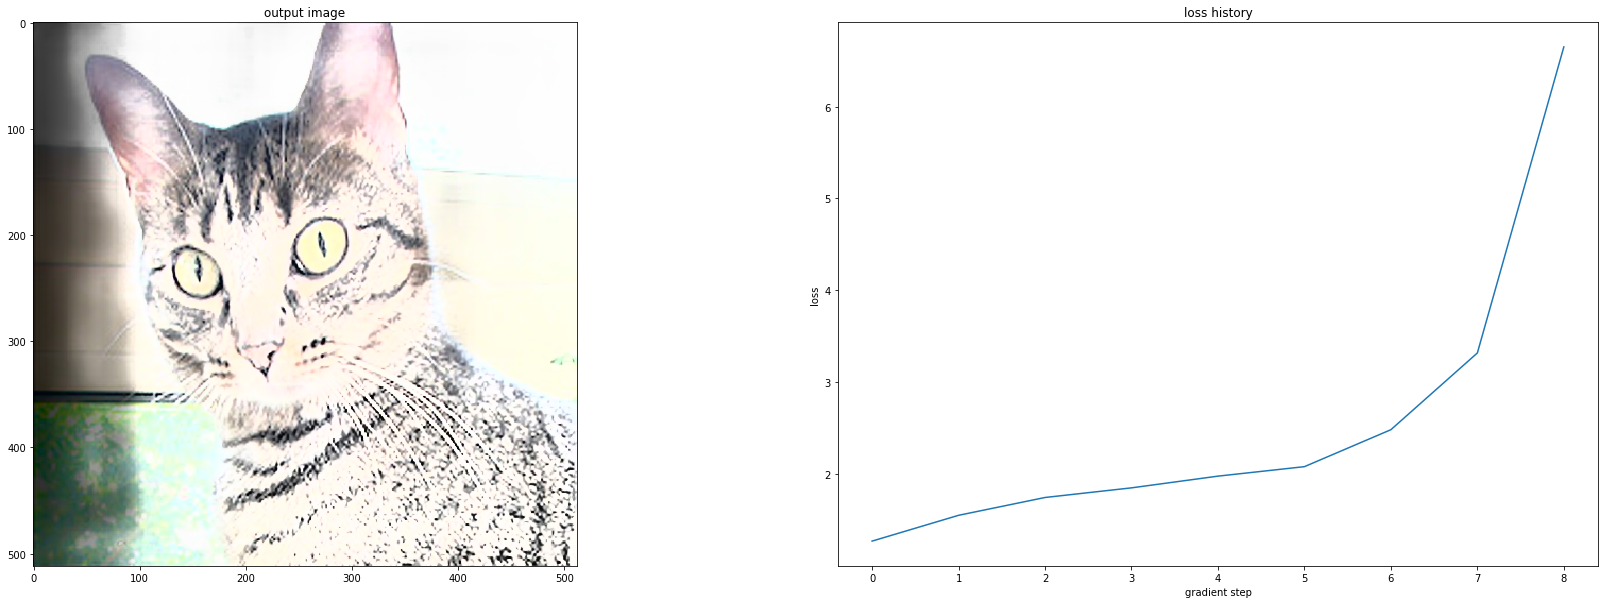

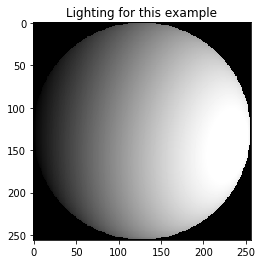

In [9]:
#with autograd.detect_anomaly(): # For debugging NaN values
with torch.enable_grad():
    for i in range(max_steps):
        
        #current_sh = sh.clone()
        sh = Variable(sh.cuda(), requires_grad=True)

        out_l, out_sh  = relighting(input_l, sh, 0)

        out_l_perm = out_l[0]
        # Rescale L* to 0 - 100
        out_l_scaled = (out_l_perm*100.0)
        output_luv = torch.cat([out_l_scaled.double(), input_uv], dim=0)

        # Transform back to RGB space for AlexNet
        output_rgb = l2r.lab_to_rgb(output_luv)

        # normalize the rgb image for alexnet
        output_rgb_norm = norm(output_rgb) 
        #output_rgb_norm = color.normalize(output_rgb, mean, std).cuda() # alternative kornia normalization

        logits = classifier(output_rgb_norm.unsqueeze(0))

        loss = nn.CrossEntropyLoss()(logits, original_label)
        loss_history.append(loss)

        # Check if generated image is already adversarial
        prediction = torch.argmax(logits)
        
        # Breaking conditions
        if targeted:
            if prediction == target_label:
                print("Successfully found targeted adversarial example after " + str(i + 1) + " steps")
                break
        else:
            # Normally you would check if original and predicted label are different
            # To make attack slightly more difficult on ImageNet, we want the difference of the label number to
            # not be trivial (empirically similar numbers are similar objects)
            if torch.abs(prediction - original_label) > 20:
            # Normal untargeted condition
            #if prediction != original_label:
                # Generated image is adversarial
                print("Successfully found adversarial example after " + str(i + 1) + " steps")
                break

        if sh.grad is not None and sh.grad.data is not None :
            sh.grad.data.zero_()

        # Currently we have not found a way to actually calculate the gradient of the luv_to_rgb function without
        # problems. Using its gradient creates many NaN values that make the overall gradient unusable
        # As a first workaround we skip this function when calculating our gradient
        # We do this by calculating 2 separate gradients one from the last node to just after the function
        # and one from just before the function to our actual variable
        loss.backward()
        #grad1 = output_rgb.grad

        #output_luv.backward(gradient=grad1)
        grad = sh.grad

        # Perform gradient ascent or descent update step based on whether we do targeted attack or not
        sh = sh + sign * learning_rate * grad
        
        #sh = current_sh.clone()
        
if targeted:
    successful = prediction == target_label
else:
    successful = prediction != original_label
    
if not successful:
    print("Attack was NOT successful")

# Show last prediction
print('original class:', int(original_label))
print('predicted class:', int(prediction))
print('SH params:', sh)

# Show the generated image

f, axarr = plt.subplots(1, 2, figsize=(30, 10))
axarr[0].imshow(output_rgb.permute(1,2,0).cpu().detach().numpy())
axarr[0].set_title('output image')
axarr[1].plot(loss_history)
axarr[1].set_title('loss history')
axarr[1].set_ylabel('loss')
axarr[1].set_xlabel('gradient step')

shading = face_utils.render_half_sphere(sh.detach().cpu())
plt.figure()
plt.title("Lighting for this example")
plt.imshow(shading, cmap='gray')